This mini-project, illustrating the use of random forests regressors, was inspired by a chapter in Modern Business Analytics by Taddy, Hendrix, and Harding, where the authors use this technique in R (instead of in Python, which we'll be using here) with 2012 wage data from the current population study (CPS). This dataset contains information about gender and education level, so it provides us with an opportunity to see how these features interact to determine wage.

The dataset is accessible from R, so we start with a small R script to convert the data into a csv file:

```
#! /usr/bin/Rscript

library(hdm)
data(cps2012)
cps <- cps2012
write.csv(cps,'pay_gap.csv')

```

Next we load some libraries, call the script from python, and clean the data up a bit:

In [2]:
import subprocess
import pandas as pd
import numpy as np

subprocess.call("./retrieve_data.R",shell=True)
pay_gap = pd.read_csv('pay_gap.csv')

# all data is from 2012 so we drop the 'year' column
to_drop = np.array([0,1,17,18,19,20,21,22,23])
pay_gap = pay_gap.drop(pay_gap.columns[to_drop],axis=1)

# rename exp1 to pexp = potential experience, which is
# the total number of years a person would have worked 
# if they had not spent time in school/college
pay_gap = pay_gap.rename({'exp1':'pexp'},axis=1)

# convert ln(hourly wage) to hourly wage
pay_gap['lnw'] = np.exp(pay_gap['lnw'])
pay_gap = pay_gap.rename({'lnw':'hrwage'},axis=1)

# meanings of the other fields:
# hsd8   = whether max education was less than 8th grade
# hsd911 = same but between grades 9 and 11
# hsg    = high school graduation
# cg     = college graduate
# ad     = advanced degree
# mw     = person lives in the US midwest
# so     = lives in southwest
# we     = lives in west

pay_gap.to_csv('pay_gap_cleaned.csv',index=False)

Now we separate the data into train and test bins, as usual, fit a random forest regressor to the training data, and see how well it performs on the test data.

In [3]:
import graphviz
import matplotlib.image as mpimg
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pay_gap = pd.read_csv('pay_gap_cleaned.csv')
y = pay_gap['hrwage']
X = pay_gap.drop(['hrwage'],axis=1)

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,train_size=0.5)
model = RandomForestRegressor(max_depth=3)
model.fit(Xtrain,ytrain)
ypred = model.predict(Xtest)
print('r2_score: ',r2_score(ytest,ypred))


r2_score:  0.137830178379455


The model explains 14% of the variation in the test data. We've allowed only trees with a depth of three (on which more in a bit), but allowing increasing this depth to doesn't substantially increase the $r^2$ score.

The random forest estimator aggregates the predictions from many individual decision trees, but we can extract one of these trees from the model and graph it to better understand what's going on.

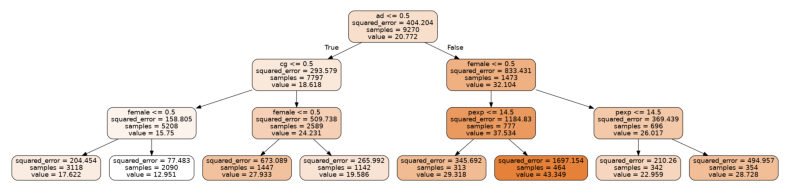

In [4]:
import graphviz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

estimator = model.estimators_[5]

dot_data = tree.export_graphviz(estimator, out_file=None,
                                feature_names=X.columns,
                                filled=True,rounded=True)

graph = graphviz.Source(dot_data, format="png")
graph.render("decision_tree_graphviz")

img = mpimg.imread('decision_tree_graphviz.png')

plt.rcParams["figure.figsize"] = [8.00, 4.50]
plt.rcParams["figure.autolayout"] = True
plt.axis('off')
plt.imshow(img)

Let's zoom into some parts of this tree, first the uppermost part or root note:

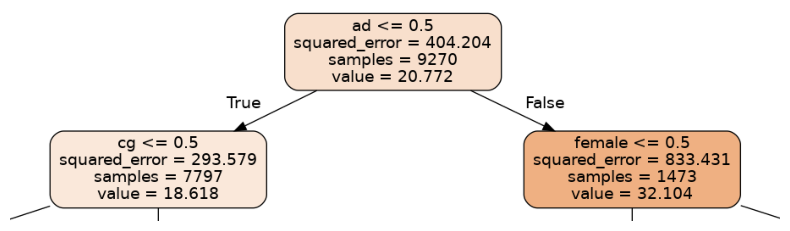

In [5]:
from PIL import Image
im = Image.open("decision_tree_graphviz.png")

crop_rectangle = (650, 0, 1560, 250)
cropped_im = im.crop(crop_rectangle)

plt.axis('off')
plt.imshow(cropped_im)

The first question being asked in this tree is whether a person in question has an advanced degree (ad=1) or not (ad=1). The left branch corresponds to a person with no advanced degree, while the right corresponds to an advanced degree holder. The expected hourly wage is shown as "value"; we can see that having a degree leads to an expected wage increase of about \\$32/hr-$18/hr = \\$14/hr.

The node on the left then splits according to whether a person has a college degree, while the node on the right splits according to gender. Let's first look at the node on the left.

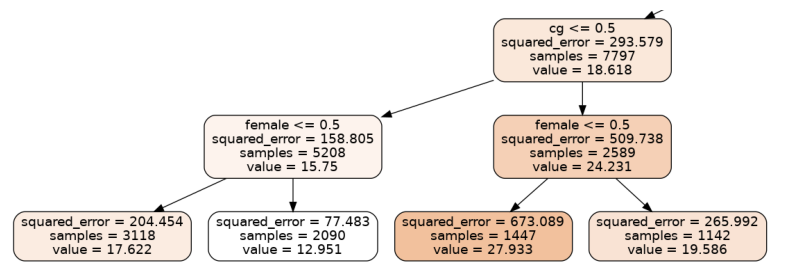

In [6]:
crop_rectangle = (0,130,1110,495)
cropped_im = im.crop(crop_rectangle)

plt.axis('off')
plt.imshow(cropped_im)

Someone with a college degree will on average make about $8/hr more than someone who doesn't, according to this tree. We also see that, among those without college degrees, men make about \\$5/hr more than women. Among those with college degrees, on the right-hand branch, those with more than 12.5 years of potential work experience tend to earn about \\$6/hr more. Now let's look at the branches to the right of the root node.

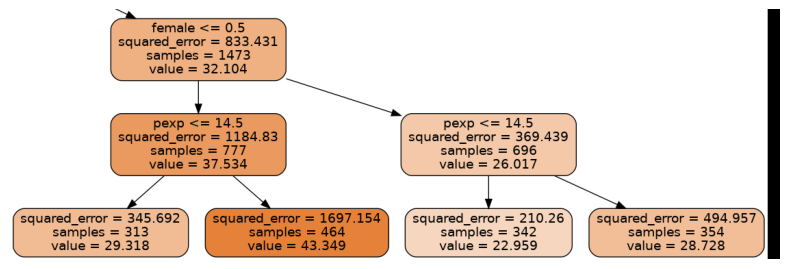

In [7]:
crop_rectangle = (1110,130,2235,495)
cropped_im = im.crop(crop_rectangle)

plt.axis('off')
plt.imshow(cropped_im)

Among those with advanced degrees, men on average make about \\$11/hr more than women, and the rest of the data is broken up according to years of potential work experience. With more experience men increase their salaries by about \\$11/hr, while women can expect an increase of about \\$5/hr. We note that this is just one tree in a random forest of 100 estimators, but the overall model shows a similar trend. For example, we can create a data set with 100 random women and another with 100 random men and see what the expected wage discrepancy is according to our model:

In [9]:
zeros_ones = np.random.randint(0,2,size=(1000,X.shape[1]))
X_men = pd.DataFrame(zeros_ones,columns=X.columns)
X_men['female'] = 0
X_men['pexp']=X.groupby(by='female').mean()['pexp'][0]
X_wom = pd.DataFrame(zeros_ones,columns=X.columns)
X_wom['female'] = 1
X_wom['pexp']=X.groupby(by='female').mean()['pexp'][1]

y_men = model.predict(X_men)
y_wom = model.predict(X_wom)
np.mean(y_men-y_wom)

10.000184078328257

Regardless of other attributes, men earn about \\$10/hr more than women. As a percentange, women in 2011 were earning about 69% of what men earned:

In [10]:
np.mean(y_wom)/np.mean(y_men)*100

69.5963960073078

These numbers are for a randomly generated population of 1000 men and women. For the actual US population, according to the [US Bureau of Labor Statistics](https://www.bls.gov/opub/reports/womens-earnings/archive/womensearnings_2012.pdf), women were earning closer to 81% of what men were in 2012.

We can also see what our data says directly about this percentage:

In [13]:
wage_men = pay_gap.groupby(by='female').mean()['hrwage'][0]
wage_wom = pay_gap.groupby(by='female').mean()['hrwage'][1]
print(wage_wom/wage_men)

0.7440769453615077
